In [1]:
import fastf1
from fastf1 import plotting
from fastf1.ergast import Ergast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Enable cache to reduce rate limit on repeated requests
fastf1.Cache.enable_cache('f1_cache')

In [7]:
# Load a Race -> example Suzuka 2025
session = fastf1.get_session(2025, 'Japan', 'Q')
session.load()

core           INFO 	Loading data for Japanese Grand Prix - Qualifying [v3.5.3]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...


req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for timing_app_data. Loading data...
_api           INFO 	Fetching timing app data...
req            INFO 	Data has been written to

In [13]:
session.laps.columns

Index(['Time', 'Driver', 'DriverNumber', 'LapTime', 'LapNumber', 'Stint',
       'PitOutTime', 'PitInTime', 'Sector1Time', 'Sector2Time', 'Sector3Time',
       'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime',
       'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'IsPersonalBest',
       'Compound', 'TyreLife', 'FreshTyre', 'Team', 'LapStartTime',
       'LapStartDate', 'TrackStatus', 'Position', 'Deleted', 'DeletedReason',
       'FastF1Generated', 'IsAccurate'],
      dtype='object')

In [16]:
laps = session.laps.pick_accurate()
laps = laps[~laps['PitOutTime'].notna() & ~laps['PitInTime'].notna()]

In [18]:
laps['S1'] = laps['Sector1Time'].dt.total_seconds()
laps['S2'] = laps['Sector2Time'].dt.total_seconds()
laps['S3'] = laps['Sector3Time'].dt.total_seconds()

In [19]:
average_s1 = laps['S1'].mean()
average_s2 = laps['S2'].mean()
average_s3 = laps['S3'].mean()

print(f"  Sector 1: {average_s1:.3f}")
print(f"  Sector 2: {average_s2:.3f}")
print(f"  Sector 3: {average_s3:.3f}")

  Sector 1: 31.995
  Sector 2: 40.512
  Sector 3: 17.872


##### Getting the sector times of all drivers from 2022 to 2025 and calculating average time per sector.

In [20]:
years = [2022, 2023, 2024, 2025]    # From 2022 because the weight limits on the car were changed in 2022 and have been consistent since.
circuit = "Japan"
sector_times = []

In [21]:
for year in years:
    session = fastf1.get_session(year, circuit, "Q")
    try:
        session.load()
        laps = session.laps.pick_accurate()
        laps = laps[~laps['PitOutTime'].notna() & ~laps['PitInTime'].notna()]
        sector1 = laps['Sector1Time'].dt.total_seconds().mean()
        sector2 = laps['Sector2Time'].dt.total_seconds().mean()
        sector3 = laps['Sector3Time'].dt.total_seconds().mean()

        sector_times.append({
                'Year': year, 'Sector1': sector1, 'Sector2': sector2, 'Sector3': sector3
            })
    except Exception as e:
        print(f"Error loading {year} {circuit} GP: {e}")

df_sector_avg = pd.DataFrame(sector_times)

logger      WARNING 	Failed to load schedule from FastF1 backend!
req            INFO 	No cached data found for season_schedule. Loading data...
_api           INFO 	Fetching season schedule...
req            INFO 	Data has been written to cache!
core           INFO 	Loading data for Japanese Grand Prix - Qualifying [v3.5.3]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...

In [22]:
df_sector_avg

,Year,Sector1,Sector2,Sector3
0,2022,32.627793,41.718414,18.723943
1,2023,31.586453,40.902160,18.140720
2,2024,31.398919,40.353919,17.804892
3,2025,31.994800,40.511690,17.871660


In [23]:
best_s1_per_driver = {}

In [26]:
for drv in session.drivers:
    laps = session.laps.pick_driver(drv).pick_accurate()
    s1_times = laps['Sector1Time'].dropna().dt.total_seconds()
    if not s1_times.empty:
        best_s1_per_driver[drv] = s1_times.min()

/opt/homebrew/lib/python3.11/site-packages/fastf1/core.py:3067: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"


In [29]:
df_all_sector1 = pd.DataFrame({
    'Driver': list(best_s1_per_driver.keys()),
    'Best_Sector1': list(best_s1_per_driver.values())
})

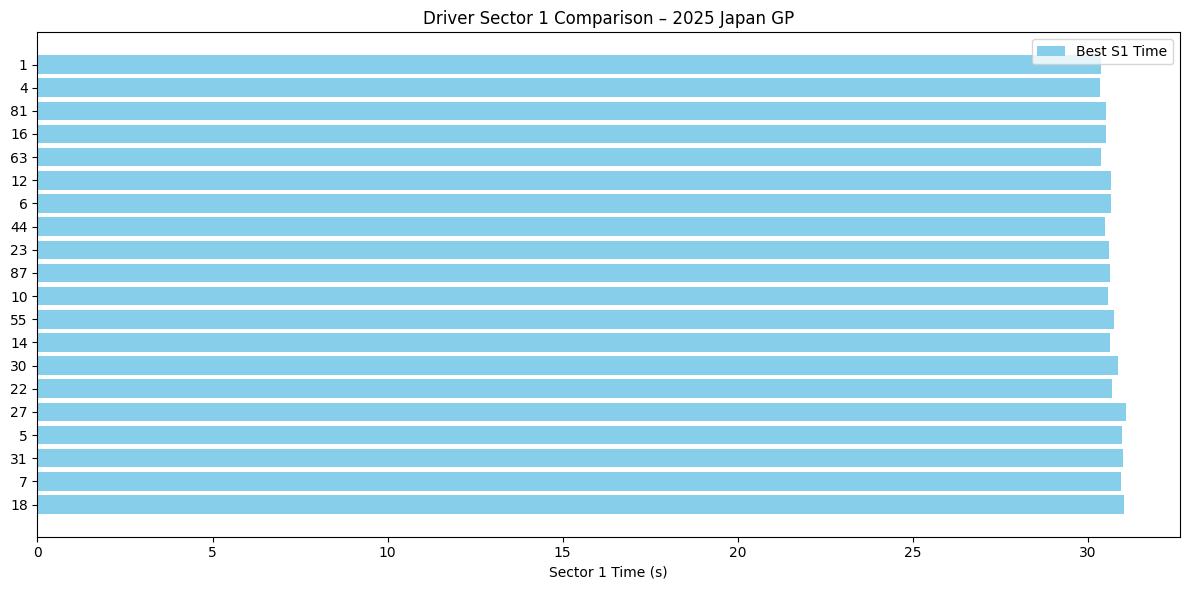

In [31]:
plt.figure(figsize=(12, 6))
plt.barh(df_all_sector1['Driver'], df_all_sector1['Best_Sector1'], color='skyblue', label='Best S1 Time')
# plt.axvline(avg_s1_time, color='red', linestyle='--', label='Avg S1 Time (2022–2025)')
plt.xlabel("Sector 1 Time (s)")
plt.title(f"Driver Sector 1 Comparison – 2025 {circuit} GP")
plt.legend()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()